In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.compat.v1.train import AdamOptimizer

In [2]:
tf.__version__

'2.15.0'

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


In [5]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [6]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(len(labels_batch.numpy()))

(32, 256, 256, 3)
[5 4 5 9 9 3 0 5 7 4 3 4 0 3 6 8 8 9 9 4 5 2 2 5 9 8 5 7 6 8 5 4]
32


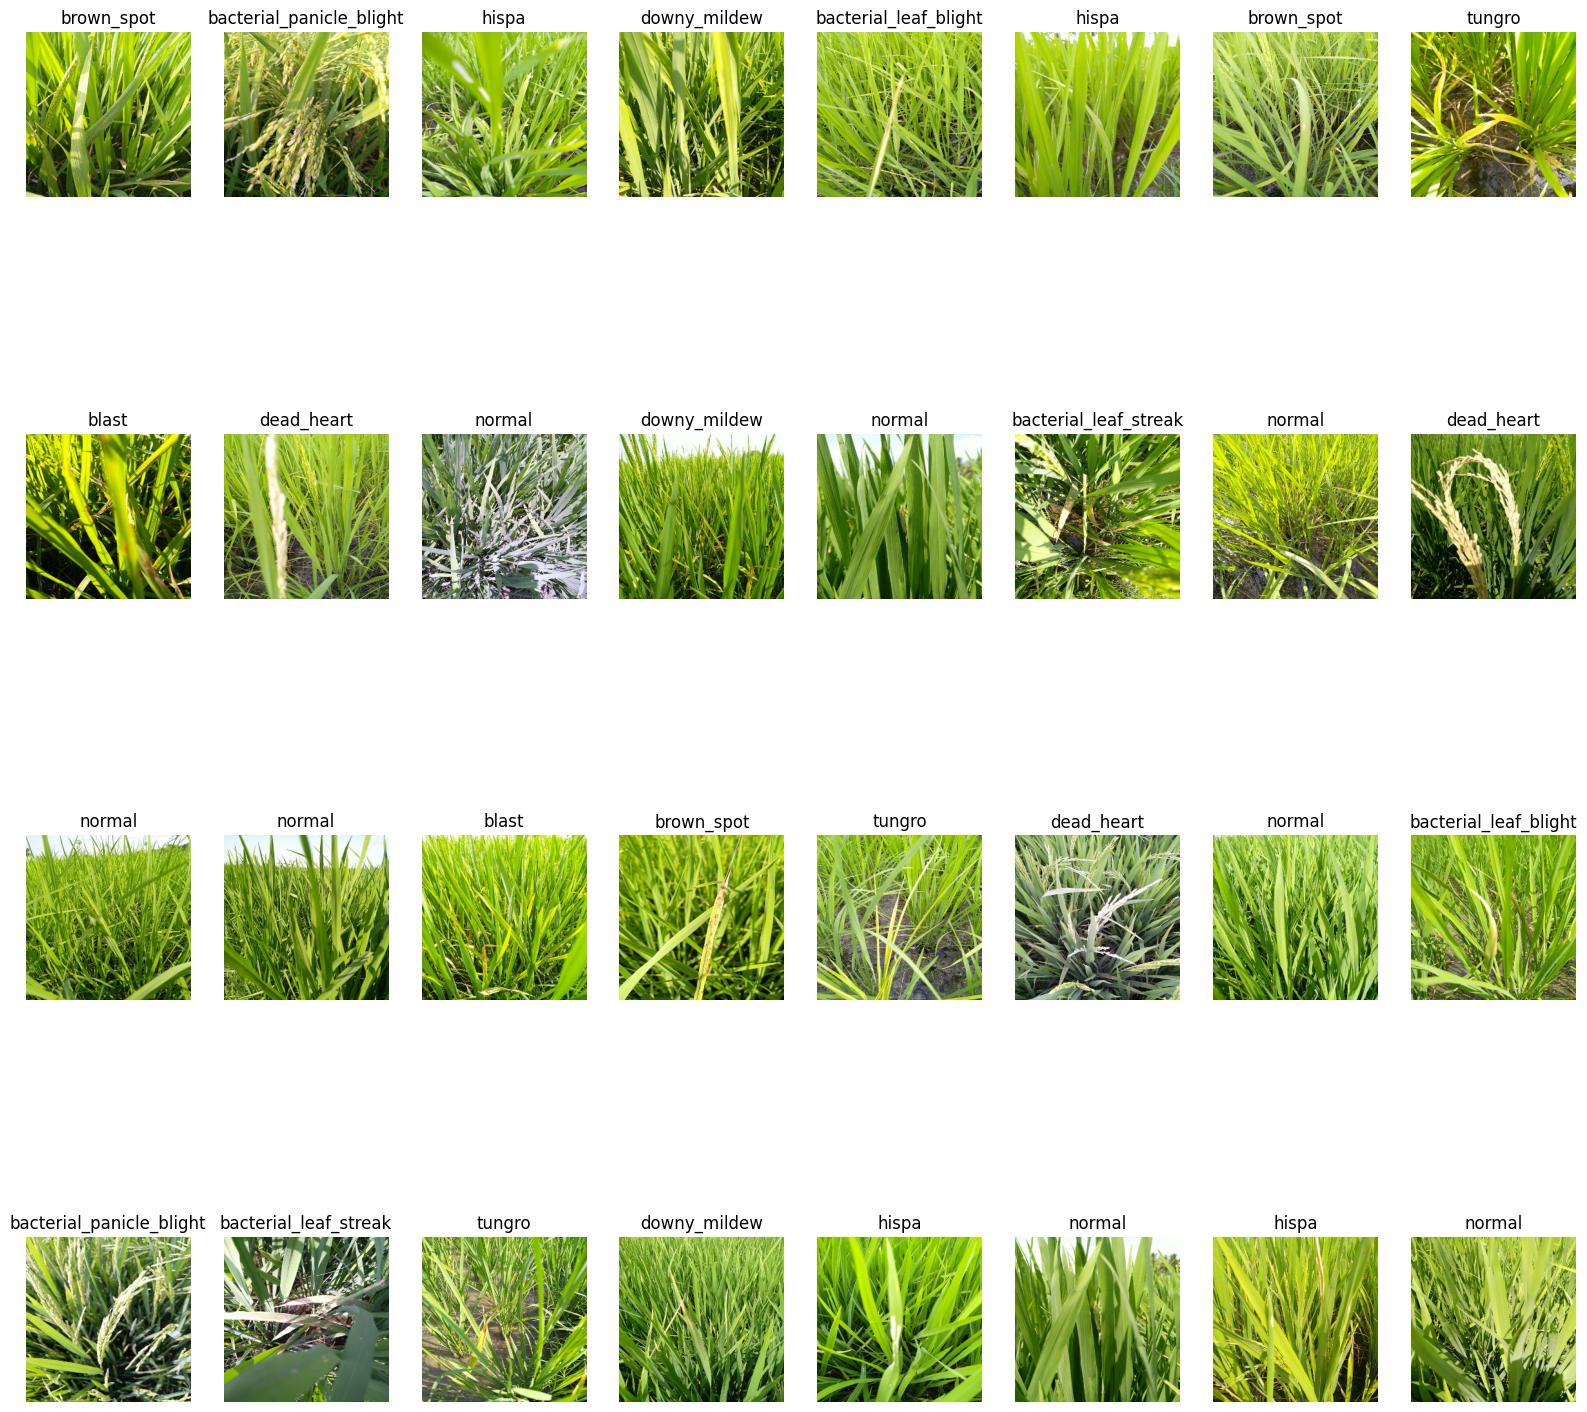

In [8]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

326

In [10]:
326*32

10432

In [11]:
len(dataset)

326

In [12]:
train_size = 0.8
len(dataset)*train_size

260.8

In [13]:
train_ds = dataset.take(261)
len(train_ds)

261

In [14]:
rem_ds = dataset.skip(261)
len(rem_ds)

65

In [15]:
val_ds = rem_ds.take(30)
len(val_ds)

30

In [16]:
test_ds = rem_ds.skip(30)
len(test_ds)

35

In [17]:
print("train dataset", train_ds)

train dataset <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [18]:
print("validation dataset", val_ds)

validation dataset <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:
print("test dataset", test_ds)

test dataset <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Cache, Shuffle and Prefetch Datasets

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch[0].numpy())
    print(len(image_batch[0].numpy()))

[[[143.03125  197.03125  121.46875 ]
  [150.76562  202.45312  131.39062 ]
  [111.25     160.07812   91.09375 ]
  ...
  [176.64062  225.82812  117.578125]
  [169.20312  214.82812  127.890625]
  [176.       218.6875   149.64062 ]]

 [[140.96875  195.71875  119.1875  ]
  [149.42188  201.28125  130.21875 ]
  [136.8125   186.8125   117.53125 ]
  ...
  [179.125    227.10938  127.71875 ]
  [170.60938  213.98438  140.28125 ]
  [186.07812  226.26562  173.28125 ]]

 [[142.01562  199.01562  120.890625]
  [142.1875   195.875    122.4375  ]
  [153.85938  204.48438  137.67188 ]
  ...
  [171.85938  219.73438  130.71875 ]
  [172.42188  215.54688  155.59375 ]
  [184.375    224.3125   183.85938 ]]

 ...

 [[ 34.515625  40.65625   55.40625 ]
  [ 39.578125  43.890625  51.828125]
  [ 24.046875  27.84375   30.96875 ]
  ...
  [  8.4375    25.        11.921875]
  [  9.578125  26.15625   16.78125 ]
  [ 40.0625    58.8125    49.8125  ]]

 [[ 31.984375  38.984375  57.1875  ]
  [ 37.03125   42.40625   54.96875 ]


## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

Resizing the image into 256x256 will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation for better accuracy

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the model using 'adam' optimizer and SparseCategoricalCrossEntroy

In [26]:
model.compile(
    optimizer=AdamOptimizer(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


261/261 [==============================] - 439s 2s/step - loss: 2.0210 - accuracy: 0.2623 - val_loss: 1.7559 - val_accuracy: 0.3792
Epoch 2/10
261/261 [==============================] - 411s 2s/step - loss: 1.6363 - accuracy: 0.4346 - val_loss: 1.5187 - val_accuracy: 0.4917
Epoch 3/10
261/261 [==============================] - 407s 2s/step - loss: 1.3505 - accuracy: 0.5443 - val_loss: 1.3178 - val_accuracy: 0.5729
Epoch 4/10
261/261 [==============================] - 404s 2s/step - loss: 1.1274 - accuracy: 0.6357 - val_loss: 1.1335 - val_accuracy: 0.6385
Epoch 5/10
261/261 [==============================] - 370s 1s/step - loss: 0.9123 - accuracy: 0.7057 - val_loss: 1.2900 - val_accuracy: 0.6219
Epoch 6/10
261/261 [==============================] - 368s 1s/step - loss: 0.7560 - accuracy: 0.7577 - val_loss: 0.8785 - val_accuracy: 0.7417
Epoch 7/10
261/261 [==============================] - 360s 1s/step - loss: 0.6233 - accuracy: 0.7933 - val_loss: 0.8526 - val_accuracy: 0.74

In [28]:
scores = model.evaluate(test_ds)

35/35 [==============================] - 22s 246ms/step - loss: 0.7735 - accuracy: 0.8055


In [29]:
scores

[0.7734751105308533, 0.8054794669151306]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 261}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

10

In [37]:
history.history['loss'][:5]

[2.0209550857543945,
 1.63625168800354,
 1.3504750728607178,
 1.127394199371338,
 0.9122892618179321]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

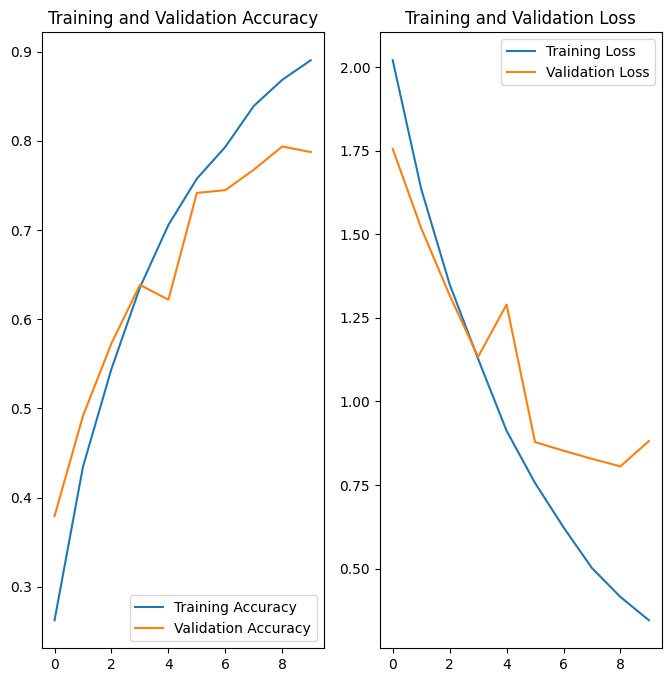

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  blast
1/1 [==============================] - 0s 418ms/step
Predicted Label : blast


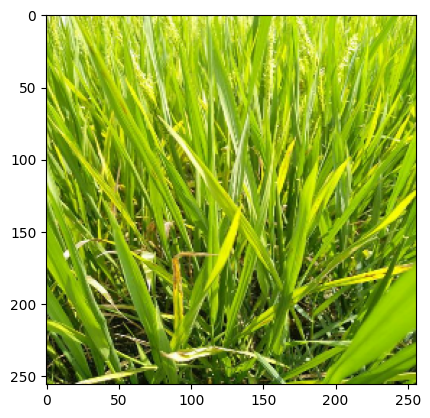

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label :", class_names[np.argmax(batch_prediction[0])])

## Function for Inference

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


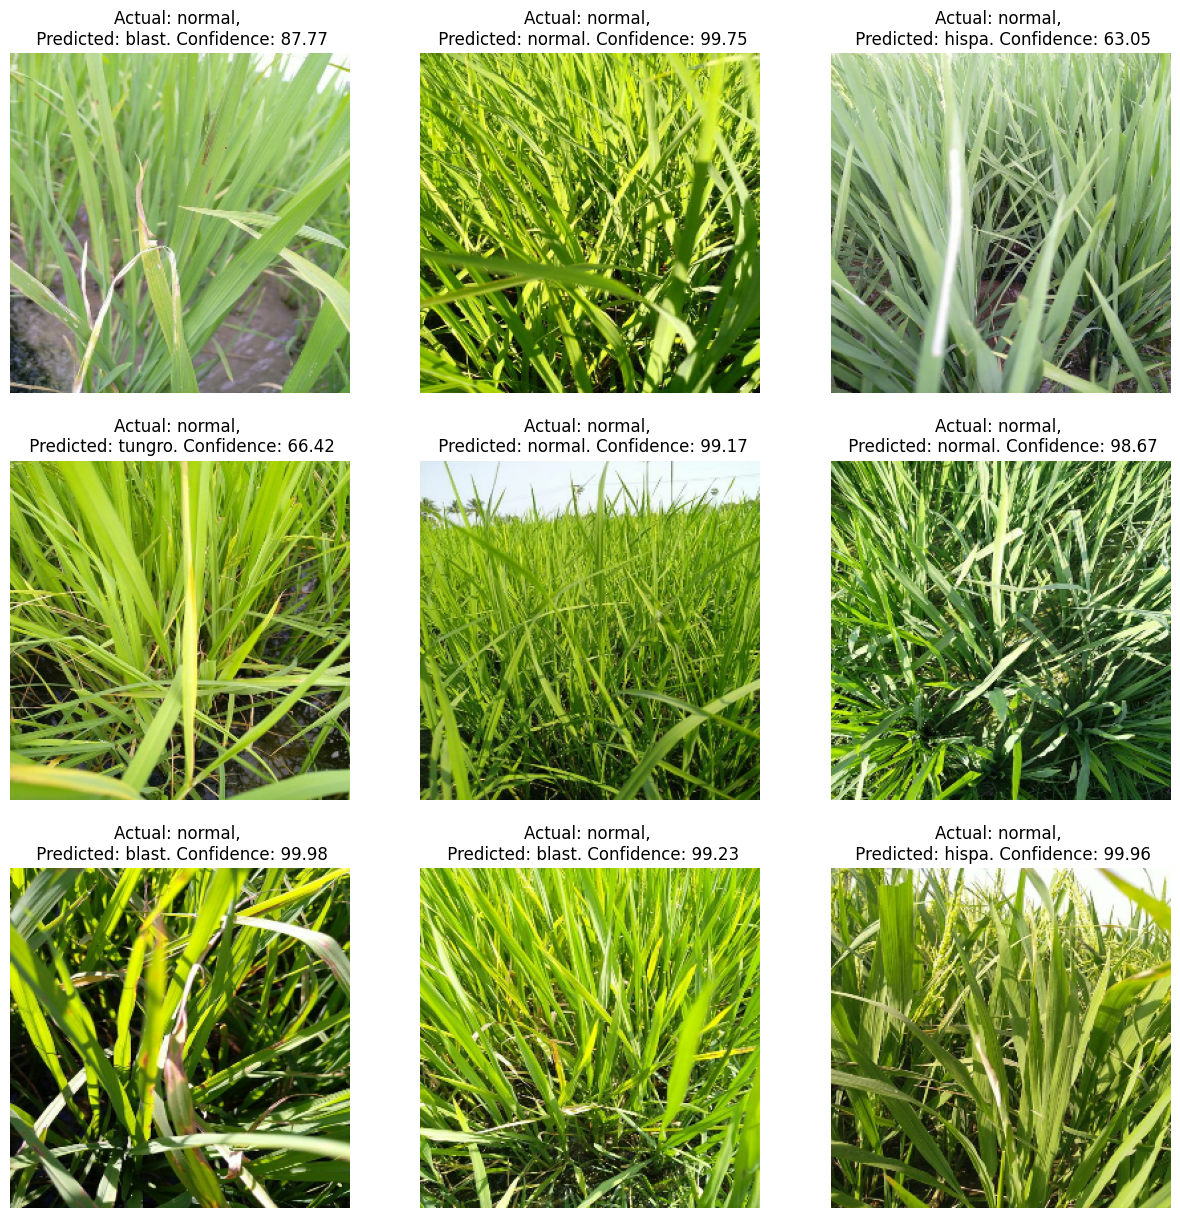

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[1]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. Confidence: {confidence}")
        plt.axis("off")

In [52]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

settings.. Level 1 DFD**

**Figure 5: Level 1 DFD**

---